In [1]:
# very slow
install.packages("BiocManager")
BiocManager::install("Biostrings")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.3 (2020-02-29)

Installing package(s) 'Biostrings'

also installing the dependencies ‘zlibbioc’, ‘S4Vectors’, ‘IRanges’, ‘XVector’


Old packages: 'ade4', 'anomalize', 'arrow', 'ARTool', 'backports',
  'BatchGetSymbols', 'bayestestR', 'biglm', 'bigparallelr', 'bigstatsr',
  'blavaan', 'boostmtree', 'brglm2', 'brms', 'broom', 'bst', 'cdata',
  'circlize', 'cli', 'clusterGeneration', 'clustMixType', 'colordistance',
  'colorspace', 'colourvalues', 'corrr', 'cplm', 'cpp11', 'cubelyr', 'cvms',
  'd3r', 'DALEX', 'data.table', 'dataPreparation', 'dbmss', 'dbplyr',
  'dcurver', 'Delaporte', 'deldir', 'dendroTools', 'Deriv', 'DiceKriging',
  'digest', 'dismo', 'doBy', 'doMC', 'doParallel', 'doSNOW', 'downlit',
  'Ecdat', 'Ecfun', 'echarts4r', 'ecp', 'effectsize', 'embed', 'emmeans',
  'EnvStats', 'Epi', 'estimatr', 'exactextractr', 'expss', 'fairness',
  'fa

In [2]:
library(tidyverse)
library(keras)
library(Biostrings)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:keras’:

    normalize


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The followi

## Reshaping data from fasta to data_frame

In [3]:
classes = c('nonpromoters', 'promoters')
sets = c('train', 'valid')

for (c in classes) {
    for (s in sets) {
        download.file(paste0("https://raw.githubusercontent.com/simecek/dspracticum2020/master/lecture_08/assignment/e_coli_promoters/e_coli_",c,"_",s,".fa"), 
              paste0("e_coli_",c,"_",s,".fa"))
    }
}

dir()

[1] "__notebook_source__.ipynb"    "e_coli_nonpromoters_train.fa"
[3] "e_coli_nonpromoters_valid.fa" "e_coli_promoters_train.fa"   
[5] "e_coli_promoters_valid.fa"

In [4]:
# for (c in classes)
#     for (s in sets)
#         dir.create(paste0('data/', s, '/', c), recursive = TRUE)

In [5]:
# for (c in classes)
#     for (s in sets) {
#         fasta <- readDNAStringSet(paste0("e_coli_",c,"_",s,".fa"))
#         for (i in 1:length(fasta)) {
#             seq <- as.character(fasta[[i]])
#             seq_with_spaces <- paste(strsplit(seq, "")[[1]], collapse = " ")
#             txtfilename <- paste0("data/", s, "/", c, "/", names(fasta)[i], ".txt") 
#             cat(seq_with_spaces, file = txtfilename, sep="\n")
#         }
#     }

# readLines("data/valid/promoters/e_coli_promoters_valid_0.txt")

dfs <- list()

for (c in classes)
    for (s in sets) {
        fasta <- readDNAStringSet(paste0("e_coli_",c,"_",s,".fa"))
        dfs[[paste(c,s)]] <- tibble(seq = as.character(fasta), c=c, s=s)
    } 
    
dset <- do.call("rbind", dfs)
print(summary(dset))

     seq                 c                  s            
 Length:7541        Length:7541        Length:7541       
 Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character  


In [6]:
seqlength = 150
train_oh <- array(0, c(sum(dset$s == "train"), seqlength, 4))
valid_oh <- array(0, c(sum(dset$s == "valid"), seqlength, 4))

dim(valid_oh)

[1] 750 150   4

In [11]:
train_ds = filter(dset, s == "train")
valid_ds = filter(dset, s == "valid")
actg = c("A", "C", "T", "G")

for (i in 1:nrow(train_ds))
    for (j in 1:seqlength) {
        bp = substring(train_ds$seq[i], j, j)
        k = which(actg == bp)
        train_oh[i, j, k] <- 1
    }

for (i in 1:nrow(valid_ds))
    for (j in 1:seqlength) {
        bp = substring(valid_ds$seq[i], j, j)
        k = which(actg == bp)
        valid_oh[i, j, k] <- 1
    }

## Transforming data

## Model

In [16]:
model_lstm = keras_model_sequential() %>%
    layer_lstm(128, input_shape = c(150, 4), return_sequences=TRUE) %>%
    layer_lstm(128, return_sequences=FALSE) %>%
    layer_dense(1, activation="sigmoid")

In [17]:
model_lstm %>% compile(
  optimizer = 'adam',
  loss = 'binary_crossentropy',
  metrics = list('accuracy')
)

In [20]:
validation_data = list(x_val=valid_oh, y_val = as.numeric(filter(dset, s == "valid")$c == 'promoters'))

history <- model_lstm %>% fit(
  train_oh,
  as.numeric(filter(dset, s == "train")$c == 'promoters'),
  epochs = 10,
  batch_size = 256,
  validation_data = validation_data,
  verbose=2
)

`geom_smooth()` using formula 'y ~ x'



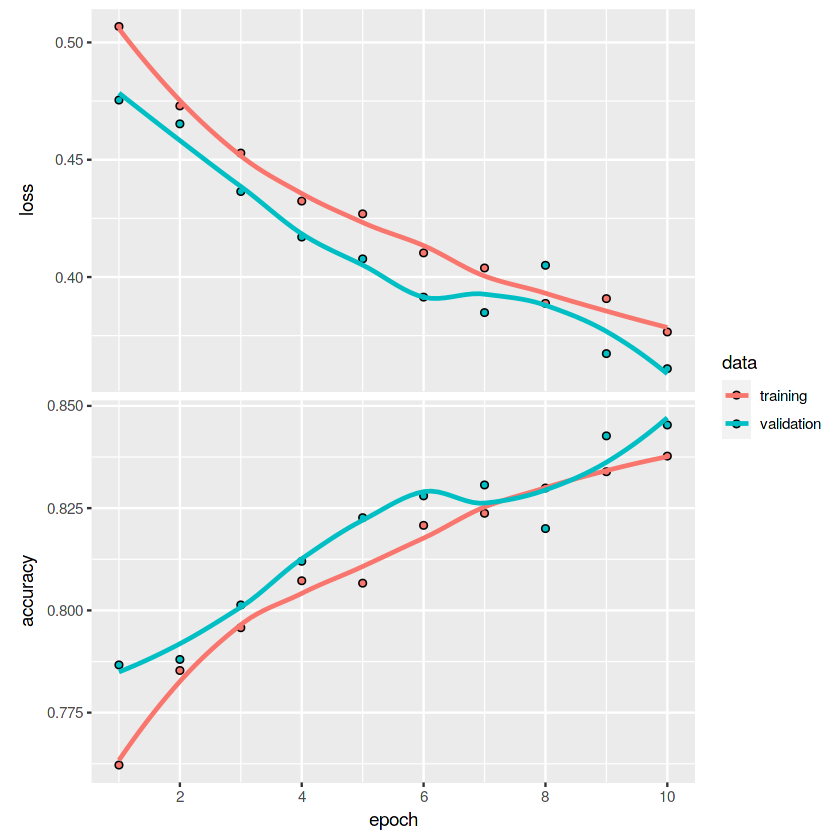

In [21]:
plot(history)

In [24]:
model_cnn = keras_model_sequential() %>%
    layer_conv_1d(32, kernel_size=6, data_format='channels_last', activation='relu') %>%
    layer_batch_normalization %>%
    layer_max_pooling_1d() %>%
    layer_conv_1d(16, kernel_size=6, data_format='channels_last', activation='relu') %>%
    layer_batch_normalization %>%
    layer_max_pooling_1d() %>%
    layer_conv_1d(4, kernel_size=6, data_format='channels_last', activation='relu') %>%
    layer_batch_normalization %>%
    layer_max_pooling_1d() %>%
    layer_dropout(0.3)  %>%
    layer_global_average_pooling_1d() %>%
    layer_dense(1, activation="sigmoid")


model_cnn %>% compile(
  optimizer = 'adam',
  loss = 'binary_crossentropy',
  metrics = list('accuracy')
)

In [ ]:
history2 <- model_cnn %>% fit(
  train_oh,
  as.numeric(filter(dset, s == "train")$c == 'promoters'),
  epochs = 10,
  batch_size = 256,
  validation_data = validation_data,
  verbose=2
)

In [ ]:
plot(history2)